# P-MEDM Toy Example

This illustration replicates an example used in Tuccillo and Spielman (2022).

* **Joseph V. Tuccillo & Seth E. Spielman** (2022) A Method for Measuring Coupled Individual and Social Vulnerability to Environmental Hazards, *Annals of the American Association of Geographers*, 112:6, 1702-1725, DOI: [10.1080/24694452.2021.1989283](https://www.tandfonline.com/doi/full/10.1080/24694452.2021.1989283)

## Setup

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-02-21T19:25:34.945765-05:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.30.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit



In [2]:
import time

import jax
import jaxlib
import jaxopt
import numpy as np
import pandas as pd
import scipy
from jax.lib import xla_bridge

import pymedm
from pymedm.diagnostics import moe_fit_rate

%watermark -w
%watermark -iv

Watermark: 2.5.0

pandas: 2.2.3
jaxopt: 0.8.3
numpy : 2.2.3
jax   : 0.4.31
pymedm: 2.2.3.dev4+g5dada73
jaxlib: 0.4.31
scipy : 1.14.1



In [3]:
pymedm.processor_availability()

,device,available,count
0,cpu,True,1
1,gpu,False,0
2,tpu,False,0


### Inputs
1. Microdata Response IDs (`serial`)
2. Microdata sample weights (`wt`)
3. Individual-Level constraints from microdata (`cind`)
4. Geographic constraints at target scale (census block groups) (`cg2` / `cbg`) and parent scale (census tracts) (`cg1` / `ctrt`)
5. Geographic constraint standard errors at target scale (census block groups) (`sg2` / `sbg`) and parent scale (census tracts) (`sg1` / `strt`)


Load the individual constraints:

In [4]:
cind = pd.read_csv("../data/toy_constraints_ind.csv")
cind.head()

,SERIAL,PERWT,POP,CONST1,CONST2,CONST3,CONST4,CONST5,CONST6
0,A,50,1,1,1,1,0,1,0
1,B,20,1,0,0,0,0,1,1
2,C,10,1,1,1,0,1,1,1
3,D,5,1,1,0,0,0,0,0
4,E,15,1,0,1,1,0,0,0


Assign the response IDs and sample weights to variables:

In [5]:
## response IDs
serial = cind.SERIAL.values

In [6]:
## sample weights
wt = cind.PERWT.values

Drop response IDs and sample weights from individual-level constraints:

In [7]:
cind = cind.drop(["SERIAL", "PERWT"], axis=1)

Next, load the geographic constraints. For this example, we will only load the target-level (block group) constraints and aggregate them to the parent level (tract) manually. With ACS data, it is more common to fetch and load these constraints separately. However, this approach can still be useful for dealing with nonstandard parent geographies (i.e., aggregating block groups to statistical neighborhoods in a city).

In [8]:
# Geographic constraints
cbg0 = pd.read_csv("../data/toy_constraints_bg.csv")
cbg0.index = cbg0.GEOID.values

In [9]:
# separate ests and standard errors
se_cols = cbg0.columns[np.where([k.endswith("s") for k in cbg0.columns])]
est_cols = cbg0.columns[
    np.where([(k not in se_cols) & (k != "GEOID") for k in cbg0.columns])
]

cbg = cbg0[est_cols]
sbg = cbg0[se_cols]

In [10]:
## Tract constraints
ctrt0 = cbg0.copy()

ctrt0.index = [str(i)[0] for i in ctrt0.GEOID.values]

ctrt0 = ctrt0.drop("GEOID", axis=1)

In [11]:
# separate ests and standard errors
ctrt = ctrt0[est_cols]
strt = ctrt0[se_cols]

In [12]:
# aggregate ests
ctrt = ctrt.groupby(ctrt.index).aggregate("sum")

In [13]:
# aggregate SE's
strt = strt.groupby(strt.index).aggregate(lambda x: np.sqrt(np.sum(np.square(x))))

The final inputs look like:

In [14]:
# Individual Constraints
cind

,POP,CONST1,CONST2,CONST3,CONST4,CONST5,CONST6
0,1,1,1,1,0,1,0
1,1,0,0,0,0,1,1
2,1,1,1,0,1,1,1
3,1,1,0,0,0,0,0
4,1,0,1,1,0,0,0


In [15]:
# Geographic constraints (target scale)
cbg

,POP,CONST1,CONST2,CONST3,CONST4,CONST5,CONST6
10,28,15,25,15,3,16,5
11,20,13,13,12,2,17,8
20,30,18,22,20,3,27,7
21,22,19,15,18,2,20,10


In [16]:
# Geographic constraint standard errors (target scale)
sbg

,POPs,CONST1s,CONST2s,CONST3s,CONST4s,CONST5s,CONST6s
10,2,1.75,2.25,3,0.5,2.75,1
11,2,1.50,2.25,2,0.5,2.75,1
20,2,1.75,2.25,2,0.5,2.75,1
21,2,1.75,2.25,2,0.5,2.75,1


In [17]:
# Geographic constraints (parent scale)
ctrt

,POP,CONST1,CONST2,CONST3,CONST4,CONST5,CONST6
1,48,28,38,27,5,33,13
2,52,37,37,38,5,47,17


In [18]:
# Geographic constraint standard errors (parent scale)
strt

,POPs,CONST1s,CONST2s,CONST3s,CONST4s,CONST5s,CONST6s
1,2.828427,2.304886,3.181981,3.605551,0.707107,3.889087,1.414214
2,2.828427,2.474874,3.181981,2.828427,0.707107,3.889087,1.414214


## Population Synthesis

<div class="alert alert-block alert-warning">
<b>Usage:</b>
    <br>• Setting 'n_reps >= 1' triggers the replicate generation workflow, which runs 'compute_hessian_matrix()'.
    <br>• The Hessian Matrix functionality within that function is highly experimental and not mature.
    <br>• Use with caution.
    <br>• Results are not guaranteed.
</div>

In [19]:
## Create P-MEDM object
pmd = pymedm.PMEDM(
    2019,
    serial,
    wt,
    cind,
    ctrt,
    cbg,
    strt,
    sbg,
    include_cg0=False,
    n_reps=1000,
    verbose=True,
)

In [20]:
## Run P-MEDM solver
start_time = time.time()
# pmd = solve(pmd)
pmd.solve()
exec_time = np.round(time.time() - start_time, 4)
print(f"\nCompleted in {exec_time} seconds.")

Initializing P-MEDM solver...
P-MEDM completed in 1.1741 seconds.

Generating 1000 replicates of the allocation matrix. The Hessian Matrix functionality here is highly experimental and not mature. Use with caution.

Replicates generated in 0.2427 seconds.

Completed in 1.4677 seconds.


### Goodness of Fit

To assess P-MEDM goodness of fit, we reconstruct the target (block group) geographic constraints from the synthetic population estimate (`pmd.almat`), compute errors, and compare the errors to the published 90% margins of error (MOE).

In [21]:
# synthetic constraints
Yhat = cind.apply(lambda x: np.sum(x.values[:, None] * pmd.almat, axis=0))

In [22]:
Yhat

,POP,CONST1,CONST2,CONST3,CONST4,CONST5,CONST6
0,27.184429,15.401235,22.672216,19.602915,3.069301,15.321880,5.285730
1,20.248196,12.773735,13.283790,11.268239,2.015551,17.428708,7.825240
2,28.351039,19.311255,23.197500,20.366542,2.830958,24.033277,7.768739
3,24.216336,17.201969,16.774845,14.710542,2.064303,23.494855,8.931491


In [23]:
cbg

,POP,CONST1,CONST2,CONST3,CONST4,CONST5,CONST6
10,28,15,25,15,3,16,5
11,20,13,13,12,2,17,8
20,30,18,22,20,3,27,7
21,22,19,15,18,2,20,10


In [24]:
# errors
err = cbg.values - Yhat.values
err

array([[ 0.81557075, -0.40123547,  2.32778429, -4.60291505, -0.06930066,
         0.6781197 , -0.28572984],
       [-0.2481956 ,  0.22626491, -0.28379004,  0.73176112, -0.01555116,
        -0.42870792,  0.17475965],
       [ 1.64896084, -1.31125454, -1.19749985, -0.36654162,  0.16904177,
         2.966723  , -0.76873911],
       [-2.21633599,  1.79803063, -1.77484478,  3.28945823, -0.06430301,
        -3.49485452,  1.06850881]])

In [25]:
# published 90% MOEs
moe = (sbg * 1.645).values
moe

array([[3.29   , 2.87875, 3.70125, 4.935  , 0.8225 , 4.52375, 1.645  ],
       [3.29   , 2.4675 , 3.70125, 3.29   , 0.8225 , 4.52375, 1.645  ],
       [3.29   , 2.87875, 3.70125, 3.29   , 0.8225 , 4.52375, 1.645  ],
       [3.29   , 2.87875, 3.70125, 3.29   , 0.8225 , 4.52375, 1.645  ]])

Check which synthetic constraints match the published MOEs:

In [26]:
moe_fit = np.abs(err) < moe
moe_fit

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

We can return the proportion of synthetic constraints matched to the published MOEs with:

In [27]:
np.sum(moe_fit.flatten()) / np.prod(moe.shape)

np.float64(1.0)

## Allocation Matrix Replicates

### Replicate 90% MOE Fit Rates

<Axes: ylabel='Frequency'>

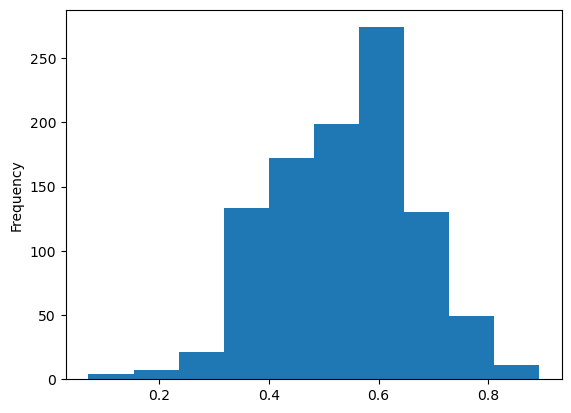

In [28]:
pd.Series(
    [moe_fit_rate(cind, cbg, sbg, s)["moe_fit_rate"] for s in pmd.almat_reps]
).plot.hist()

### Variation in allocation ests - single cell

In [29]:
sim_almats = np.array(pmd.almat_reps)

In [30]:
rep_ests_onecell = [sim_almats[i][0][0] for i in range(sim_almats.shape[0])]

<Axes: ylabel='Frequency'>

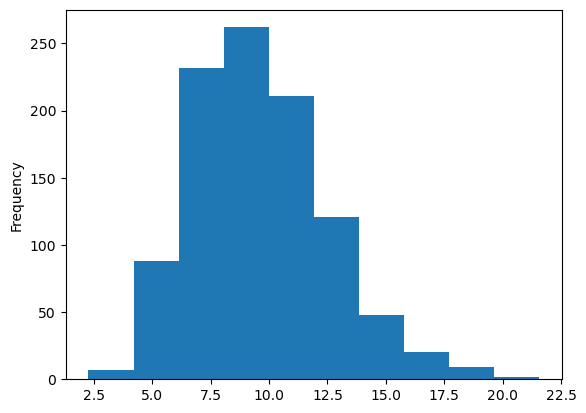

In [31]:
pd.Series(rep_ests_onecell).plot.hist()

### Coefficients of Variation: all replicate ests

In [32]:
almat_cv = np.std(sim_almats, axis=0) / np.mean(sim_almats, axis=0)

<Axes: ylabel='Frequency'>

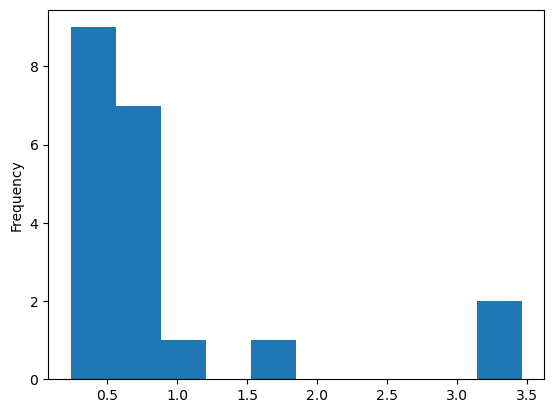

In [33]:
pd.Series(almat_cv.flatten()).plot.hist()